In [1]:
import os
os.chdir("/zhome/be/1/138857/EHR_sensor_representations/scripts")  

In [2]:
import sys
import os
from mortality_part_preprocessing import load_pad_separate
from mortality_part_preprocessing import MortalityDataset, PairedDataset
from models.regular_transformer import EncoderClassifierRegular
from models.early_stopper import EarlyStopping
from models.deep_set_attention import DeepSetAttentionModel
from models.grud import GRUDModel
from models.ip_nets import InterpolationPredictionModel
from torch.utils.data import DataLoader
import tqdm
import torch
import torch.nn as nn

In [15]:
import numpy as np
file = "normalization_physionet2012_1.json"
path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/P12data/"
import json
with open(path + file, "r") as f:
    norm_data = json.load(f)
# Print time-series feature names
print(type(norm_data["ts_means"]))  # Should print <class 'list'>
print(len(norm_data["ts_means"]))   # How many elements?
print(norm_data["ts_means"][:5])    

<class 'list'>
37
[83.11079574756315, 119.44102735156771, 359.6545383880742, 513.2573910788382, 2.894396249926148]


In [6]:
dataset_id = "physionet2012"  # Change this if needed
base_path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/P12data/split_1"  # Path to extracted files
split_index = 1  # Choose the dataset split
save_path = "./processed_datasets"  # Where the preprocessed data will be stored

# Load the dataset
mortality_pair, mortality_val, mortality_test = load_pad_separate(
    dataset_id, base_path, split_index, save_path
)

Loading preprocessed datasets from ./processed_datasets
Loaded dataset from ./processed_datasets/physionet2012_1_pos.h5
Loaded dataset from ./processed_datasets/physionet2012_1_neg.h5
Loaded dataset from ./processed_datasets/physionet2012_1_val.h5
Loaded dataset from ./processed_datasets/physionet2012_1_test.h5


In [ ]:
batch_size = 64
train_pair = mortality_pair
train_batch_size = batch_size // 2 

train_collate_fn = PairedDataset.paired_collate_fn_truncate
train_dataloader = DataLoader(train_pair, train_batch_size, shuffle=True, num_workers=16, collate_fn=train_collate_fn, pin_memory=True)
train_dataloader = DataLoader(train_pair, train_batch_size, shuffle=True, num_workers=16, collate_fn=train_collate_fn, pin_memory=True)

In [5]:
train_dataloader

In [ ]:
c = 0 
for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
    c += 1
    if c < 2:
        data, times, static, labels, mask, delta = batch
        print(data)
    else:
        break 

In [9]:
def get_one_hot_features(num_features, batch_size, time_steps, device):
    """
    Creates a one-hot encoding matrix for all features and generates corresponding mask and delta.

    Args:
    - num_features (int): Number of original features in X.
    - batch_size (int): Number of samples in the batch.
    - time_steps (int): Number of time steps (sequence length).
    - device (str): CUDA or CPU device.

    Returns:
    - feature_one_hot (torch.Tensor): One-hot encoded feature matrix.
    - one_hot_mask (torch.Tensor): Corresponding mask for one-hot features.
    - one_hot_delta (torch.Tensor): Corresponding delta values (zero since one-hot is static).
    """

    # Identity matrix for one-hot encoding (F, F)
    feature_one_hot = torch.eye(num_features, device=device)  # Shape: (F, F)

    # Expand to match batch and time dimensions
    feature_one_hot = feature_one_hot.unsqueeze(0).unsqueeze(2)  # Shape: (1, F, 1, F)
    feature_one_hot = feature_one_hot.expand(batch_size, -1, time_steps, -1)  # Shape: (B, F, T, F)

    # Reshape for concatenation with data (flatten the one-hot encoding)
    feature_one_hot = feature_one_hot.reshape(batch_size, num_features * num_features, time_steps)  # (B, F*F, T)

    # Create a corresponding mask (1s for all one-hot encoded features)
    one_hot_mask = torch.ones_like(feature_one_hot, dtype=torch.float32, device=device)  # (B, F*F, T)

    # Create a corresponding delta (0s since one-hot encoding does not change over time)
    one_hot_delta = torch.zeros_like(feature_one_hot, dtype=torch.float32, device=device)  # (B, F*F, T)

    return feature_one_hot, one_hot_mask, one_hot_delta


def train(
    train_dataloader,
    val_dataloader,
    output_path,
    epochs,
    patience,
    device,
    model_type,
    lr,
    early_stop_criteria,
    model_args,
    expand_features=True,  # NEW: Toggle one-hot encoding
    **kwargs,  
):
    """
    Training function with an option to expand feature space using one-hot encoding.
    """

    # assign GPU
    if torch.cuda.is_available():
        dev = "cuda"
    else:
        dev = "cpu"
    device = torch.device(dev)
    
    iterable_inner_dataloader = iter(train_dataloader)
    test_batch = next(iterable_inner_dataloader)
    max_seq_length = test_batch[0].shape[2]  # Time steps (T)
    sensor_count = test_batch[0].shape[1]  # Features (F)
    static_size = test_batch[2].shape[1]  # Static feature size

    # Define the model
    if model_type == "grud":
        model = GRUDModel(
            input_dim=sensor_count + (sensor_count * sensor_count if expand_features else 0),  # Adjust for expanded input
            static_dim=static_size,
            output_dims=2,
            device=device,
            recurrent_n_units=128,  #ADDED
            recurrent_dropout=0.3, #ADDED 
            dropout=0.0, #ADDED 
            **model_args
        )
    elif model_type == "ipnets":
        model = InterpolationPredictionModel(
            output_dims=2,
            sensor_count=sensor_count + (sensor_count if expand_features else 0),  # Adjust for expanded input
            **model_args
        )
    elif model_type == "seft":
        model = DeepSetAttentionModel(
            output_activation=None,
            n_modalities=sensor_count + (sensor_count if expand_features else 0),
            output_dims=2,
            **model_args
        )
    elif model_type == "transformer":
        model = EncoderClassifierRegular(
            num_classes=2,
            device=device,
            max_timepoint_count=max_seq_length,
            sensors_count=sensor_count + (sensor_count if expand_features else 0),
            static_count=static_size,
            return_intermediates=False,
            **model_args
        )

    criterion = nn.CrossEntropyLoss()  # Loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(
        patience=patience, verbose=True, path=f"{output_path}/checkpoint.pt"
    )  

    # Training loop
    for epoch in range(epochs):
        model.train().to(device)
        loss_list = []

        c = 0 
        for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):

            data, times, static, labels, mask, delta = batch

            # Create one-hot encoding for features and concatenate
            batch_size = data.shape[0]
           # Get expanded one-hot encoded features, mask, and delta
            one_hot_features, one_hot_mask, one_hot_delta = get_one_hot_features(sensor_count, batch_size, data.shape[2], device)

            # Concatenate one-hot encoding to data, mask, and delta
            data = torch.cat([data, one_hot_features], dim=1)
            mask = torch.cat([mask, one_hot_mask], dim=1)
            delta = torch.cat([delta, one_hot_delta], dim=1)

            if model_type != "grud":
                data = data.to(device)
                static = static.to(device)
                times = times.to(device)
                mask = mask.to(device)
                delta = delta.to(device)

            optimizer.zero_grad()

            predictions = model(
                x=data, static=static, time=times, sensor_mask=mask, delta=delta
            )
            predictions = predictions.squeeze(-1)
            loss = criterion(predictions.cpu(), labels)
            loss_list.append(loss.item())

            loss.backward()
            optimizer.step()

        accum_loss = np.mean(loss_list)

        # Validation step
        model.eval().to(device)
        labels_list = torch.LongTensor([])
        predictions_list = torch.FloatTensor([])

        with torch.no_grad():
            for batch in val_dataloader:
                data, times, static, labels, mask, delta = batch

                # Create one-hot encoding for features and concatenate
                batch_size = data.shape[0]
                one_hot_features, one_hot_mask, one_hot_delta = get_one_hot_features(sensor_count, batch_size, data.shape[2], device)

                # Concatenate one-hot encoding to data, mask, and delta
                data = torch.cat([data, one_hot_features], dim=1)
                mask = torch.cat([mask, one_hot_mask], dim=1)
                delta = torch.cat([delta, one_hot_delta], dim=1)

                if model_type != "grud":
                    data = data.to(device)
                    static = static.to(device)
                    times = times.to(device)
                    mask = mask.to(device)
                    delta = delta.to(device)

                predictions = model(
                    x=data, static=static, time=times, sensor_mask=mask, delta=delta
                )
                predictions = predictions.squeeze(-1)
                predictions_list = torch.cat((predictions_list, predictions.cpu()), dim=0)
        
        val_loss = criterion(predictions_list.cpu(), labels_list)

        print(f"Epoch: {epoch+1}, Train Loss: {accum_loss}, Val Loss: {val_loss}")

        if early_stop_criteria == "loss":
            early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    return val_loss, model



In [10]:
dataset_id = "physionet2012"  # Change this if needed
base_path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/P12data/split_1"  # Path to extracted files
split_index = 1  # Choose the dataset split
save_path = "./processed_datasets"  # Where the preprocessed data will be stored

# Load the dataset
train_pair, val, test = load_pad_separate(
    dataset_id, base_path, split_index, save_path
)

batch_size = 64 // 2

train_loader = DataLoader(train_pair, batch_size, shuffle=True, num_workers=16, collate_fn=PairedDataset.paired_collate_fn_truncate, pin_memory=True)
val_loader = DataLoader(val, batch_size, shuffle=True, num_workers=16, collate_fn=MortalityDataset.non_pair_collate_fn_truncate, pin_memory=True)

train_loss, trained_model = train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    output_path="./results",
    epochs=2,
    patience=5,
    device="cuda",
    model_type="grud",
    lr=0.001,
    early_stop_criteria="loss",
    model_args={},
    expand_features=True  # Enable one-hot encoding
)


Loading preprocessed datasets from ./processed_datasets
Loaded dataset from ./processed_datasets/physionet2012_1_pos.h5
Loaded dataset from ./processed_datasets/physionet2012_1_neg.h5
Loaded dataset from ./processed_datasets/physionet2012_1_val.h5
Loaded dataset from ./processed_datasets/physionet2012_1_test.h5


 17%|██████████████████████▌                                                                                                          | 22/126 [00:55<04:23,  2.53s/it]


KeyboardInterrupt: 

In [33]:
37*37+37

1406

In [4]:
sensor_count = 37
expand_features = True
test = sensor_count + (sensor_count * sensor_count if expand_features else 0)
print(test)

1406


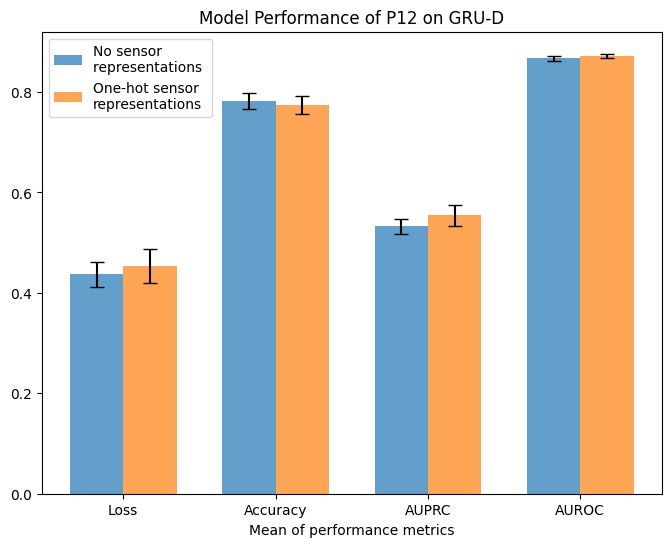

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load JSON data from two files
file1 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_3/summary.json"  # Replace with actual file name
file2 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_2/summary.json"  # Replace with actual file name

with open(file1, "r") as f:
    data1 = json.load(f)

with open(file2, "r") as f:
    data2 = json.load(f)

# Extract metrics
metrics = ["mean_loss", "mean_accuracy", "mean_auprc", "mean_auroc"]
std_metrics = ["std_loss", "std_accuracy", "std_auprc", "std_auroc"]

means1 = [data1[m] for m in metrics]
means2 = [data2[m] for m in metrics]

stds1 = [data1[s] for s in std_metrics]
stds2 = [data2[s] for s in std_metrics]

# Plot bar chart
x_labels = ["Loss", "Accuracy", "AUPRC", "AUROC"]
x = np.arange(len(metrics))
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, means1, width, yerr=stds1, capsize=5, label="No sensor \nrepresentations ", alpha=0.7)
bars2 = ax.bar(x + width/2, means2, width, yerr=stds2, capsize=5, label="One-hot sensor \nrepresentations", alpha=0.7)

# Labels and formatting
ax.set_xlabel("Mean of performance metrics")
ax.set_ylabel("")
ax.set_title("Model Performance of P12 on GRU-D")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.show()


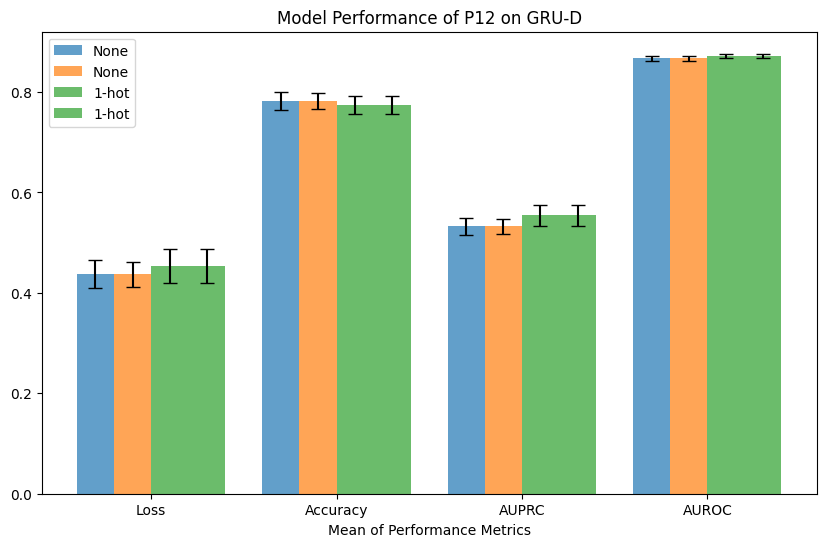

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load JSON data from four files
file1 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_1/summary.json"
file2 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_3/summary.json"
file3 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_2/summary.json"  # New
file4 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_4/summary.json"  # New

with open(file1, "r") as f:
    data1 = json.load(f)
with open(file2, "r") as f:
    data2 = json.load(f)
with open(file3, "r") as f:
    data3 = json.load(f)
with open(file4, "r") as f:
    data4 = json.load(f)

# Extract metrics
metrics = ["mean_loss", "mean_accuracy", "mean_auprc", "mean_auroc"]
std_metrics = ["std_loss", "std_accuracy", "std_auprc", "std_auroc"]

means1 = [data1[m] for m in metrics]
means2 = [data2[m] for m in metrics]
means3 = [data3[m] for m in metrics]
means4 = [data4[m] for m in metrics]

stds1 = [data1[s] for s in std_metrics]
stds2 = [data2[s] for s in std_metrics]
stds3 = [data3[s] for s in std_metrics]
stds4 = [data4[s] for s in std_metrics]

# Plot bar chart
x_labels = ["Loss", "Accuracy", "AUPRC", "AUROC"]
x = np.arange(len(metrics))
width = 0.2  # Adjust width for 4 bars

fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red

bars1 = ax.bar(x - 1.5 * width, means1, width, yerr=stds1, capsize=5, label="None", alpha=0.7, color=colors[0])
bars2 = ax.bar(x - 0.5 * width, means2, width, yerr=stds2, capsize=5, label="None", alpha=0.7, color=colors[1])
bars3 = ax.bar(x + 0.5 * width, means3, width, yerr=stds3, capsize=5, label="1-hot", alpha=0.7, color=colors[2])
bars4 = ax.bar(x + 1.5 * width, means4, width, yerr=stds4, capsize=5, label="1-hot", alpha=0.7, color=colors[2])


# Labels and formatting
ax.set_xlabel("Mean of Performance Metrics")
ax.set_ylabel("")
ax.set_title("Model Performance of P12 on GRU-D")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.show()


In [10]:
# Load JSON data from four files
file1 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_3/summary.json"
file2 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_5/summary.json"
file3 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_2/summary.json"  # New
file4 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_4/summary.json"  # New

with open(file1, "r") as f:
    data1 = json.load(f)
with open(file2, "r") as f:
    data2 = json.load(f)
with open(file3, "r") as f:
    data3 = json.load(f)
with open(file4, "r") as f:
    data4 = json.load(f)

# Extract metrics
metrics = ["mean_loss", "mean_accuracy", "mean_auprc", "mean_auroc"]
std_metrics = ["std_loss", "std_accuracy", "std_auprc", "std_auroc"]

means1 = [data1[m] for m in metrics]
means2 = [data2[m] for m in metrics]
means3 = [data3[m] for m in metrics]
means4 = [data4[m] for m in metrics]

stds1 = [data1[s] for s in std_metrics]
stds2 = [data2[s] for s in std_metrics]
stds3 = [data3[s] for s in std_metrics]
stds4 = [data4[s] for s in std_metrics]

print(means1[1], means2[1], means3[1], means4[1])

0.7734778982485405 0.7734778982485405 0.7734778982485405 0.7734778982485405


In [21]:
 # assign GPU
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)

data = torch.rand(2,2,1)

N = data.shape[0]
F = data.shape[1]
T = data.shape[2]

one_hot = torch.eye(F, device=device).flatten().unsqueeze(0).unsqueeze(2)
one_hot = torch.cat([one_hot] * N, dim=0)
one_hot = torch.cat([one_hot] * T, dim=2)

In [174]:

def get_one_hot_features(data, device):

    # Identity matrix for one-hot encoding (F, F)
    N = data.shape[0]
    F = data.shape[1]
    T = data.shape[2]

    one_hot = torch.eye(F, device=device).flatten().unsqueeze(0).unsqueeze(2)
    one_hot = torch.cat([one_hot] * N, dim=0)
    one_hot = torch.cat([one_hot] * T, dim=2)

    # Create a corresponding mask (1s for all one-hot encoded features)
    one_hot_mask = torch.ones_like(one_hot, dtype=torch.float32, device=device)

    # Create a corresponding delta (0s since one-hot encoding does not change over time)
    one_hot_delta = torch.zeros_like(one_hot, dtype=torch.float32, device=device)

    return one_hot, one_hot_mask, one_hot_delta

if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)

F = 37
data = torch.rand(1,F,3)

one_hot_features ,_ ,_ = get_one_hot_features(data, device = device) 

N = 1
T = 2

data_a = torch.round(torch.cat([data, one_hot_features], dim=1), decimals=1)

print(data_a.shape)
#test_list = [f"{x:.1f}" for x in data_a[N,:F+(F*F),T].tolist()]

#for i in range(0,len(test_list),F):
#    print(test_list[i:i+F])


torch.Size([1, 1406, 3])
